# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

Основные шаги:

1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

## Подготовка данных

### Загрузим билиотеки

Сюда же будем подгружать библиотеки по мере необходимости.

In [ ]:
!pip install phik
!pip install missingno
!pip install phik
!pip install scikit-learn==1.1.3

In [ ]:
!pip install lightgbm

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

import phik
from phik.report import plot_correlation_matrix
from phik import report
import missingno as msno

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

import phik
from phik.report import plot_correlation_matrix
from phik import report


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from catboost import Pool, CatBoostRegressor, cv

In [ ]:
RANDOM_STATE=12345

### Функции для анализа данных

In [ ]:
def check_data(data):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data.info())
    #print(data_df.shape)

    missed_cells = data.isnull().sum().sum()/(data.shape[0]*(data.shape[1]-1))
    missed_rows = sum(data.isnull().sum(axis = 1)>0)/data.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data.head())

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data.describe(include='object').T)


    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data[i].value_counts())

    print('\033[1m' + '\nНазвания колонок:'+ '\033[0m')
    for column in data.columns:
        print(column)

In [ ]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})

    for i, col in enumerate(col_column):
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

In [ ]:
def plot_hist_cat(data, col_column, cat):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    #col_column.append(cat)
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})

    for i, col in enumerate(col_column):
        #print(data[[col, cat]])
        sns.histplot(data = data[[col, cat]], x = data[col], kde=True, bins=24, ax = ax[i, 0], hue = cat)
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

In [ ]:
#pd.set_option('display.max_rows', None)

### Загрузим данные

In [ ]:
#PATH_OUT = r'C:\Users\Tania\Desktop\Учеба\Численные_методы\Проект'

In [ ]:
#data = pd.read_csv(PATH_OUT + '\\autos.csv')

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

In [ ]:
check_data(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dt

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0



Описание категориальных данных:


,count,unique,top,freq
DateCrawled,354369,271174,2016-03-24 14:49:47,7
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161
DateCreated,354369,109,2016-04-03 00:00:00,13719
LastSeen,354369,179150,2016-04-06 13:45:54,17



Вывод уникальных значений по каждому категориаьному признаку:
_DateCrawled


2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-05 14:25:23    5
2016-04-02 14:50:21    5
                      ..
2016-03-23 11:57:35    1
2016-03-22 18:55:48    1
2016-04-04 16:43:48    1
2016-03-15 12:58:10    1
2016-03-10 17:46:49    1
Name: DateCrawled, Length: 271174, dtype: int64

_VehicleType


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

_Gearbox


manual    268251
auto       66285
Name: Gearbox, dtype: int64

_Model


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

_FuelType


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

_Brand


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

_Repaired


no     247161
yes     36054
Name: Repaired, dtype: int64

_DateCreated


2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
                       ...  
2016-01-08 00:00:00        1
2016-01-18 00:00:00        1
2016-01-16 00:00:00        1
2015-06-18 00:00:00        1
2015-12-17 00:00:00        1
Name: DateCreated, Length: 109, dtype: int64

_LastSeen


2016-04-06 13:45:54    17
2016-04-06 09:17:58    16
2016-04-06 09:46:00    16
2016-04-07 05:44:30    16
2016-04-06 10:15:26    16
                       ..
2016-03-16 16:25:09     1
2016-03-31 02:44:22     1
2016-03-14 13:44:16     1
2016-03-29 12:42:30     1
2016-03-23 04:21:13     1
Name: LastSeen, Length: 179150, dtype: int64


Названия колонок:
DateCrawled
Price
VehicleType
RegistrationYear
Gearbox
Power
Model
Kilometer
RegistrationMonth
FuelType
Brand
Repaired
DateCreated
NumberOfPictures
PostalCode
LastSeen


Все хорошо, данные загрузились нормально. Есть пропуски и дубликаты. Обратим на них внимание дальше.

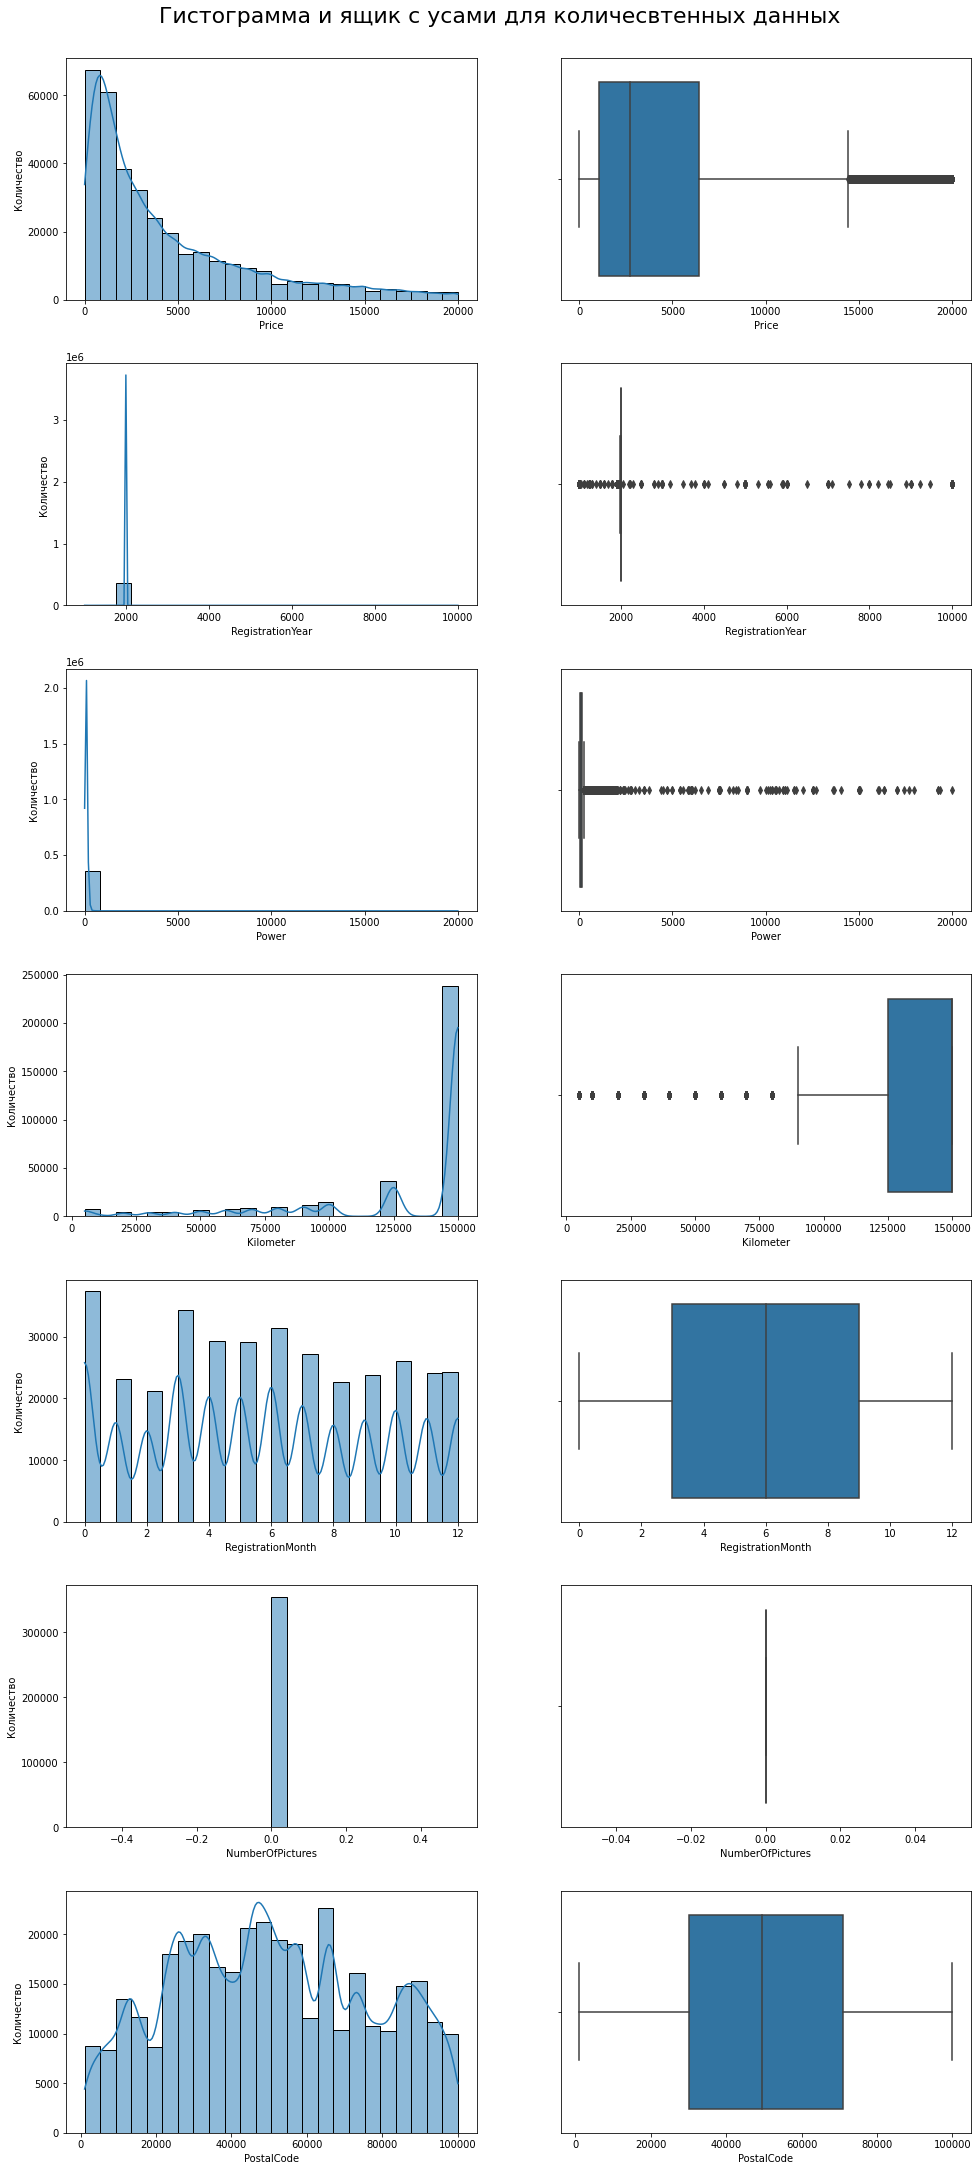

In [ ]:
# ГРАФИЧЕСКИЙ АНАЛИЗ количественных данных данных
plot_hist(data, data.select_dtypes(exclude=[object]).columns)

Есть выбросы, посмотрим на на них дальше, если это потребуется.

### Посмотри на пропуски и дубли

<AxesSubplot:>

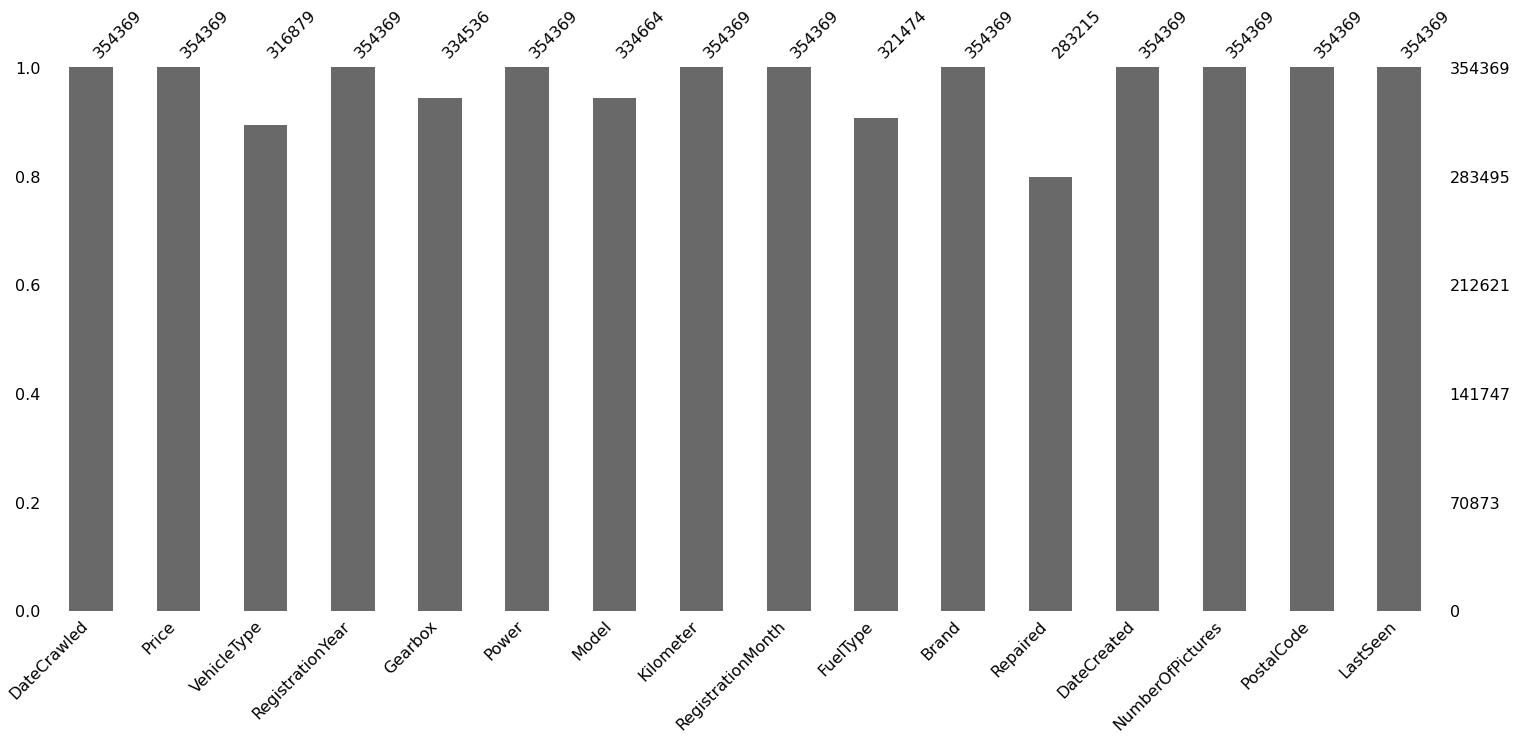

In [ ]:
msno.bar(data)

Пропуски присутствуют:

Repaired — была машина в ремонте или нет

FuelType — тип топлива

Model — модель автомобиля

Gearbox — тип коробки передач

VehicleType — тип автомобильного кузова

In [ ]:
#data['RegistrationYear'].unique()
data['RegistrationYear'].sort_values(ascending=True)

244092    1000
91869     1000
143621    1000
55605     1000
164397    1000
          ... 
167937    9999
217111    9999
149151    9999
326725    9999
224832    9999
Name: RegistrationYear, Length: 354369, dtype: int64

In [ ]:
data[data['RegistrationYear'] > 2017].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
163,2016-04-04 12:57:02,1200,NaN,2018,manual,75,astra,150000,0,NaN,opel,no,2016-04-04 00:00:00,0,15344,2016-04-06 14:45:26
196,2016-03-24 13:51:03,2800,NaN,2018,manual,75,twingo,125000,12,NaN,renault,no,2016-03-24 00:00:00,0,86199,2016-04-07 05:17:27
355,2016-03-12 19:00:11,1050,NaN,2018,NaN,0,golf,150000,0,NaN,volkswagen,NaN,2016-03-12 00:00:00,0,53567,2016-04-07 10:44:48


Чудеса, последние объявления добавлены в 2016 году, а уже продаются авто 2017 и 2018 года выпуска. Явные фейки, удаляем. Так же все машины ниже 1919 года.

In [ ]:
#data['DateCreated'].value_counts()

In [ ]:
data['DateCreated'].sort_values(ascending=False)

323825    2016-04-07 00:00:00
238423    2016-04-07 00:00:00
218464    2016-04-07 00:00:00
8823      2016-04-07 00:00:00
136456    2016-04-07 00:00:00
                 ...         
175103    2015-08-10 00:00:00
86601     2015-08-07 00:00:00
342275    2015-06-18 00:00:00
4001      2015-03-20 00:00:00
61207     2014-03-10 00:00:00
Name: DateCreated, Length: 354369, dtype: object

была машина в ремонте или нет мы не определим, а в этом пункте самые большие пропуски. Считаю не стоит тратить время на востановление данных, да их и не так много всего 3,4% Удаляем

In [ ]:
# Вывод всех задублированных строк
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Дубли не явные, но тоже можно удалить. Считаю на качество данных не повлияет.

In [ ]:
#data = data.dropna()

In [ ]:
for i in ['Repaired', 'Gearbox', 'Model', 'FuelType', 'VehicleType']:
    data[i]=data[i].fillna('other')

In [ ]:
#data.isna().sum()

Так же удалим все не информативные столбцы. Которые точно не влияют на финальный результат.

In [ ]:
data = data.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)

<AxesSubplot:>

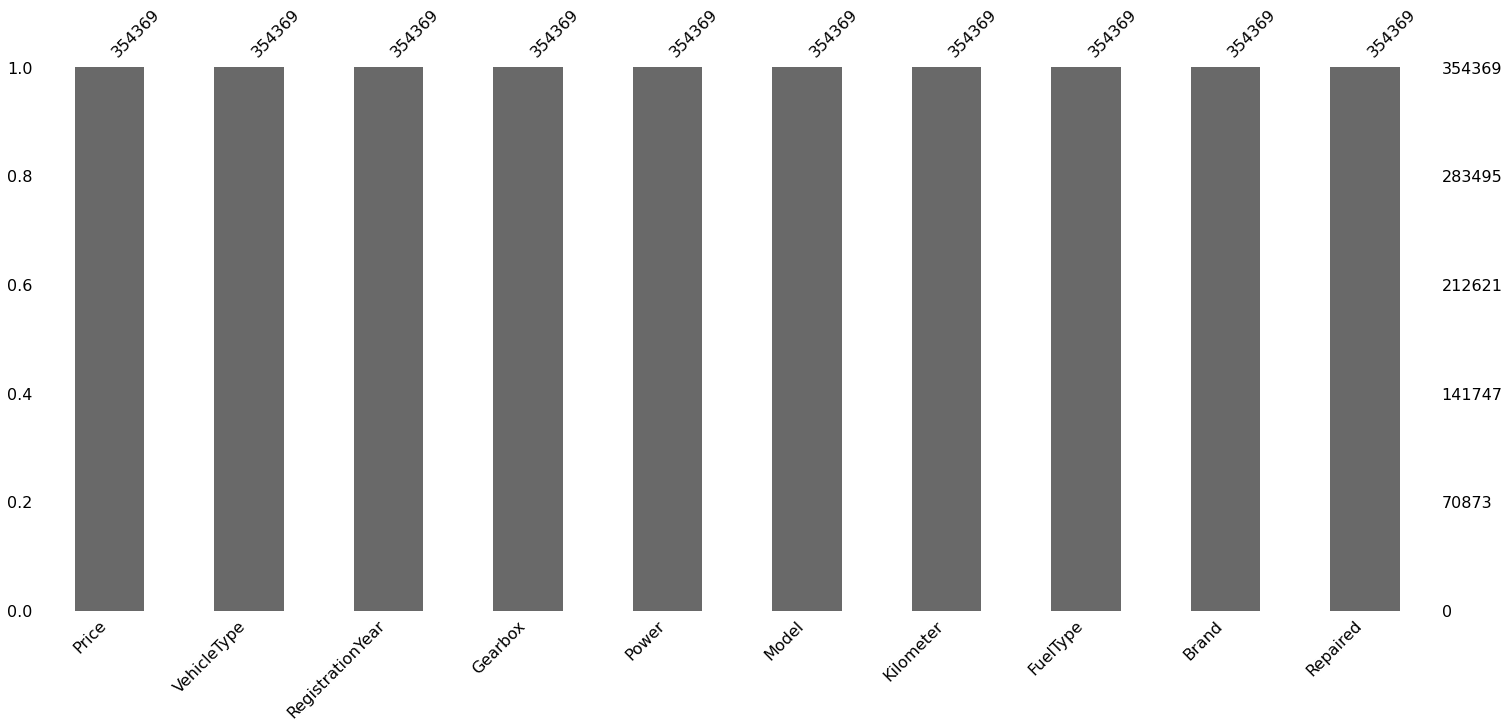

In [ ]:
msno.bar(data)


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data[data.duplicated()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


Все хорошо, пропуск и дубликаты удалены.

In [ ]:
data.columns = data.columns.str.lower()

In [ ]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,other
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309178 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             309178 non-null  int64 
 1   vehicletype       309178 non-null  object
 2   registrationyear  309178 non-null  int64 
 3   gearbox           309178 non-null  object
 4   power             309178 non-null  int64 
 5   model             309178 non-null  object
 6   kilometer         309178 non-null  int64 
 7   fueltype          309178 non-null  object
 8   brand             309178 non-null  object
 9   repaired          309178 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.9+ MB


In [ ]:
#data['registrationyear'].value_counts()
data['registrationyear'].unique()


array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [ ]:
#data[data['registrationyear'] > 2017].head(130)

In [ ]:
#data['registrationyear'].plot.bar(figsize=(15, 6))

In [ ]:
#auto_year = data.pivot_table(index = 'registrationyear', values = 'price', aggfunc = 'count')

In [ ]:
data = data[data['registrationyear'] < 2017]

In [ ]:
data[data['registrationyear'] < 1919]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
15,450,small,1910,other,0,ka,5000,petrol,ford,other
622,0,other,1111,other,0,other,5000,other,opel,other
6629,0,small,1910,other,0,other,5000,other,sonstige_autos,other
6977,135,other,1910,other,0,other,5000,other,opel,other
10183,1250,other,1910,other,0,other,5000,other,audi,other
...,...,...,...,...,...,...,...,...,...,...
334901,1300,other,1910,other,0,other,5000,other,audi,other
340759,700,other,1600,manual,1600,a3,150000,petrol,audi,no
348830,1,other,1000,other,1000,other,150000,other,sonstige_autos,other
351682,11500,other,1800,other,16,other,5000,petrol,fiat,other


In [ ]:
data = data[data['registrationyear'] > 1919]

In [ ]:
auto_year = data.pivot_table(index = 'registrationyear', values = 'price')

<AxesSubplot:xlabel='registrationyear'>

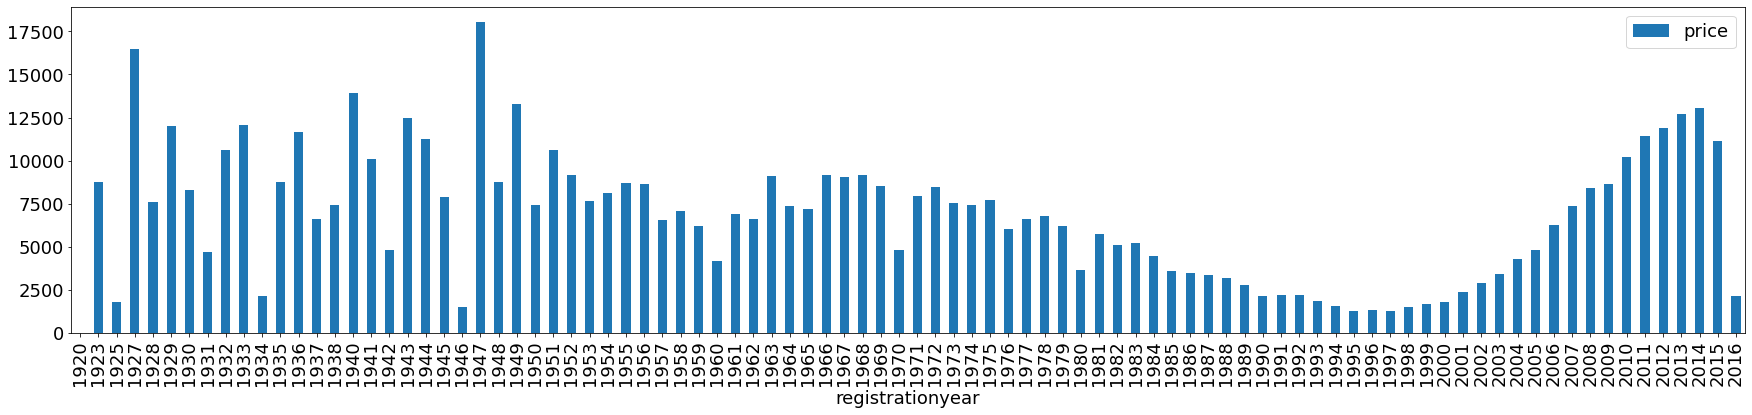

In [ ]:
auto_year.plot.bar(figsize=(30, 6))

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data, y='price', x='registrationyear')
# ax = plt.gca()
# ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=20))

Резделим на категории ретро, поддержанные и новые. Линейность где-то пропадает на 1985 году. Ну и округлим до 30 лет, будем считать, что машины старше 30 лет переходят в категорию ретро.

In [ ]:

def categorize(registrationyear): # создайте функцию categorize
    if registrationyear <= 1985:
        return "retro"
    elif 1986 <= registrationyear <= 2015:
        return "used_car"
    return "new"


In [ ]:
#data['categorize'].value_counts()
data['categorize'] = (data['registrationyear'].apply(categorize))
data['categorize'].value_counts()

used_car    280698
new           9005
retro         5746
Name: categorize, dtype: int64

In [ ]:
data[data['price'] < 10]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,categorize
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,retro
40,0,other,1990,other,0,corsa,150000,petrol,opel,other,used_car
59,1,suv,1994,manual,286,other,150000,other,sonstige_autos,other,used_car
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,used_car
115,0,small,1999,other,0,other,5000,petrol,volkswagen,other,used_car
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,other,2000,manual,65,corsa,150000,other,opel,yes,used_car
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,other,used_car
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,other,used_car
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,used_car


Бесплатные машины так же уберем.

In [ ]:
data = data[data['price'] > 10]

In [ ]:
data['price'].value_counts()

500      4445
1500     4257
1000     3604
1200     3563
2500     3525
         ... 
836         1
5247        1
11955       1
8225        1
8188        1
Name: price, Length: 3684, dtype: int64

<AxesSubplot:xlabel='price'>

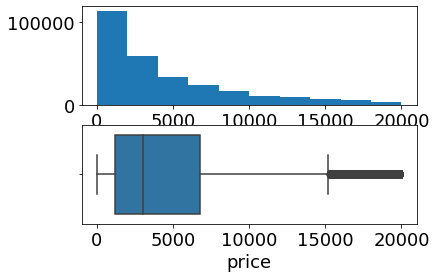

In [ ]:
plt.subplot(2,1,1)
plt.hist(x=data['price'])

plt.subplot(2,1,2)
sns.boxplot(data['price'])

Посмотрим на выбросы.

In [ ]:
data[data['price'] > 15000]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,categorize
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,used_car
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no,used_car
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no,used_car
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no,used_car
179,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no,used_car
...,...,...,...,...,...,...,...,...,...,...,...
354187,15190,bus,2011,manual,140,touran,80000,petrol,volkswagen,no,used_car
354279,16500,suv,2013,manual,116,i_reihe,30000,gasoline,hyundai,no,used_car
354286,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes,retro
354306,16999,wagon,2008,auto,269,a6,150000,gasoline,audi,no,used_car


Считаю в полне логичным.

In [ ]:
# plt.subplot(2,1,1)
# plt.hist(x=data['power'],bins=10)

# plt.subplot(2,1,2)
# sns.boxplot(data['power'])

In [ ]:
#data = data[data['price'] > 10]
data = data[data['power'] < 400]

ОСтавим авто с мощьностью до 400 ЛС, все же больше это что то запредельное для массового сегмента.

### Корреляционный анализ данных

In [ ]:
# применим phik_matrix
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer']


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,categorize
price,1.00,0.28,0.59,0.29,0.52,0.57,0.31,0.27,0.36,0.37,0.14
vehicletype,0.28,1.00,0.18,0.37,0.50,0.90,0.18,0.40,0.62,0.30,0.57
registrationyear,0.59,0.18,1.00,0.11,0.23,0.57,0.33,0.21,0.37,0.21,0.78
gearbox,0.29,0.37,0.11,1.00,0.56,0.61,0.07,0.32,0.51,0.44,0.25
power,0.52,0.50,0.23,0.56,1.00,0.77,0.11,0.29,0.56,0.32,0.19
model,0.57,0.90,0.57,0.61,0.77,1.00,0.44,0.53,1.00,0.27,0.49
kilometer,0.31,0.18,0.33,0.07,0.11,0.44,1.00,0.16,0.27,0.24,0.16
fueltype,0.27,0.40,0.21,0.32,0.29,0.53,0.16,1.00,0.29,0.24,0.22
brand,0.36,0.62,0.37,0.51,0.56,1.00,0.27,0.29,1.00,0.15,0.34
repaired,0.37,0.30,0.21,0.44,0.32,0.27,0.24,0.24,0.15,1.00,0.28


В данном случае необходимо обратить внимание на на строку "price" в принципе все логично и это радует, но так же на отсутствие корреляции

Text(0.5, 1.0, 'Phik Correlation Matrix')

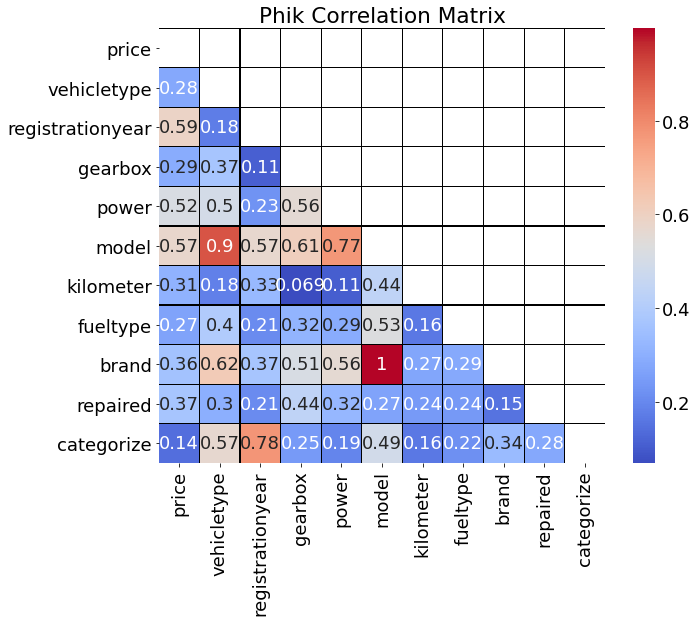

In [ ]:
def phik_matrix(data):
    phik_overview = data.phik_matrix(interval_cols=['price', 'registrationyear', 'power', 'kilometer'])

mask = np.triu(np.ones_like(phik_overview, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', linewidths=0.1, linecolor='black', mask=mask)
plt.title('Phik Correlation Matrix')



## Обучение моделей

Подготовим выборки для обучения моделей.

Моделей будет несколько и делить данные будем так же по раздельности. Модель CatBoost работает как с категориальными так и численные признаки.  

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 285495 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             285495 non-null  int64 
 1   vehicletype       285495 non-null  object
 2   registrationyear  285495 non-null  int64 
 3   gearbox           285495 non-null  object
 4   power             285495 non-null  int64 
 5   model             285495 non-null  object
 6   kilometer         285495 non-null  int64 
 7   fueltype          285495 non-null  object
 8   brand             285495 non-null  object
 9   repaired          285495 non-null  object
 10  categorize        285495 non-null  object
dtypes: int64(4), object(7)
memory usage: 26.1+ MB


In [ ]:
df = data

Раздели на три выборки: обучающая, валидационная, тестовая (60/20/20)

In [ ]:
features = df.drop('price', axis=1)
target = df['price']

In [ ]:

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

print('Обучающая выборка     _train', features_train.shape)
print('Валидационная выборка _valid', features_valid.shape)
print('Тестовая выборка       _test', features_test.shape)

Обучающая выборка     _train (171297, 10)
Валидационная выборка _valid (57099, 10)
Тестовая выборка       _test (57099, 10)


Воспользуемся One-Hot Encoding, в данной функии заложено fit, т е обучение. В дальнейшем использовании, можель может обучаться сама.

In [ ]:

ohe_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired', 'categorize']

encoder_ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
encoder_ohe.fit(features_train[ohe_features])

features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
features_train_linear = features_train.drop(ohe_features, axis=1)

features_train_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes,categorize_retro,categorize_used_car
224692,2000,75,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
159259,2010,122,50000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8058,2011,90,60000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196903,1996,90,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
67838,2004,75,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


С работало.

In [ ]:
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
features_test_linear = features_test.drop(ohe_features, axis=1)

In [ ]:
features_test_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes,categorize_retro,categorize_used_car
138737,2009,60,90000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89586,2016,56,150000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
244219,2011,86,100000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
50087,2002,86,125000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
263478,2003,115,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid[ohe_features])
features_valid_linear = features_valid.drop(ohe_features, axis=1)


In [ ]:
features_valid_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes,categorize_retro,categorize_used_car
56716,2003,340,125000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106324,2012,60,5000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
191556,1997,102,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
243508,2005,130,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38445,2006,204,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Все хорошо, разделилось ровно.

Применим StandardScaler для масштабирования.

In [ ]:

numeric = ['registrationyear', 'power', 'kilometer']

scaler = StandardScaler()

scaler.fit(features_train_linear[numeric])

features_train_linear[numeric] = scaler.transform(features_train_linear[numeric])

features_train_linear.head()

#display(features_train_linear.head())

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes,categorize_retro,categorize_used_car
224692,-0.378728,-0.54490,0.598804,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
159259,1.051135,0.21227,-2.024580,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8058,1.194122,-0.30325,-1.762242,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196903,-0.950673,-0.30325,0.598804,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
67838,0.193218,-0.54490,0.598804,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
scaler.fit(features_test_linear[numeric])

features_valid_linear[numeric] = scaler.transform(features_valid_linear[numeric])

features_valid_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes,categorize_retro,categorize_used_car
56716,0.050499,3.760236,-0.053856,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106324,1.347652,-0.787286,-3.192167,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
191556,-0.814270,-0.105157,0.599958,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
243508,0.338755,0.349595,0.599958,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38445,0.482883,1.551440,0.599958,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
scaler.fit(features_test_linear[numeric])

features_test_linear[numeric] = scaler.transform(features_test_linear[numeric])

features_test_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes,categorize_retro,categorize_used_car
138737,0.915268,-0.787286,-0.969197,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89586,1.924165,-0.852250,0.599958,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
244219,1.203524,-0.365016,-0.707671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
50087,-0.093629,-0.365016,-0.053856,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
263478,0.050499,0.105977,0.599958,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Отлично, все работает.

Перезапишем в привычный формат features_train ...

In [ ]:
features_train_ohe = features_train_linear
features_valid_ohe = features_valid_linear
features_test_ohe = features_test_linear

### Linear Regression Модель

In [ ]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train_ohe, target_train)

CPU times: user 13.8 s, sys: 16.3 s, total: 30 s
Wall time: 30 s


LinearRegression()

In [ ]:
%%time
model_test_lr = lr_model.predict(features_valid_ohe)

CPU times: user 92.8 ms, sys: 155 ms, total: 248 ms
Wall time: 272 ms


In [ ]:
mse_model_lr = mean_squared_error(target_valid, model_test_lr)
print("RMSE на тестовой выборке для линейной регресии:", round((mse_model_lr) ** 0.5, 2))

RMSE на тестовой выборке для линейной регресии: 2540.48


Почти добились нужного результата))

### RandomizedSearchCV

Подберем гиперпараметры методом RandomizedSearchCV. Забегая впред, закомментируе код, тк выполняется он давольно долго.

In [ ]:
#%%time

#parameters = {'n_estimators': range(1,101,25),'max_depth': range(3,8,2)}

#model_rfr = RandomForestRegressor()

#rscv = RandomizedSearchCV(model_rfr, parameters, scoring='neg_mean_squared_error')
#rscv.fit(features_train, target_train)

#print(rscv.best_params_)
# Результат:
# {'n_estimators': 51, 'max_depth': 7}
# Wall time: 44min 27s
# Parser   : 495 ms

### Random Forest Regressor Модель

In [ ]:
# # features_train_rfr = features_train.copy()
# # features_test_rfr = features_test.copy()

# features_train_rfr = features_train
# features_test_rfr = features_test

# category_features_rfr = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired', 'categorize']

# encoder = OrdinalEncoder()
# encoder.fit(features_train_rfr[category_features_rfr])
# features_train_rfr[category_features_rfr] = encoder.transform(features_train_rfr[category_features_rfr])
# features_test_rfr[category_features_rfr] = encoder.transform(features_test_rfr[category_features_rfr])

# features_train_rfr.head()

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired', 'categorize']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])


In [ ]:
%%time

model_rfr_test = RandomForestRegressor(n_estimators = 51, max_depth=7, random_state=12345)
model_rfr_test.fit(features_train_ord, target_train)

CPU times: user 1min 21s, sys: 479 ms, total: 1min 22s
Wall time: 1min 22s


RandomForestRegressor(max_depth=7, n_estimators=51, random_state=12345)

In [ ]:
%%time

preds_rfrmodel = model_rfr_test.predict(features_valid_ord)

CPU times: user 207 ms, sys: 148 ms, total: 355 ms
Wall time: 361 ms


In [ ]:
%%time

mse_preds_rfrmodel = mean_squared_error(target_valid, preds_rfrmodel)
print("RMSE для DecisionTreeRegresso модели на тестовой выборке:", round((mse_preds_rfrmodel) ** 0.5, 2))

RMSE для DecisionTreeRegresso модели на тестовой выборке: 2176.42
CPU times: user 2.24 ms, sys: 0 ns, total: 2.24 ms
Wall time: 1.43 ms


Ура, уже лучшее но идем дальше.

### LightGBM Модель (градиентный бустинг)

В отличии от предыдущей модели в данной для подбора гиперпараметров используем GridSearchCV

In [ ]:
# %%time
# cv = 3
# gbm = LGBMRegressor(boosting_type='gbdt', seed=RANDOM_STATE)
# gbm_params = {'learning_rate': [0.1, 0.5], 'n_estimators': [50, 100], 'max_depth': [4]}

# grid_gbm = GridSearchCV(gbm, gbm_params, cv=cv)
# grid_gbm.fit(features_train_ord, target_train);

# grid_gbm.best_params_

# Результат
# CPU times: user 21min 12s, sys: 20.3 s, total: 21min 32s
# Wall time: 21min 38s
# {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100}

In [ ]:
%%time

model_gbm = LGBMRegressor(learning_rate = 0.4, max_depth = 4, n_estimators = 100)
model_gbm.fit(features_train_ord, target_train)

CPU times: user 15.7 s, sys: 441 ms, total: 16.2 s
Wall time: 16.3 s


LGBMRegressor(learning_rate=0.4, max_depth=4)

In [ ]:
%%time

preds_gbmmodel = model_gbm.predict(features_valid_ord)

CPU times: user 435 ms, sys: 111 ms, total: 546 ms
Wall time: 596 ms


In [ ]:
%%time

mse_preds_gbmmodel = mean_squared_error(target_valid, preds_gbmmodel)
print("RMSE для LightGBM модели на тестовой выборке:", round((mse_preds_gbmmodel) ** 0.5, 2))

RMSE для LightGBM модели на тестовой выборке: 1752.41
CPU times: user 2.92 ms, sys: 329 µs, total: 3.25 ms
Wall time: 1.95 ms


Успех с каждым разом. RMSE становится все меньше.

### CatBoost Regressor

Вернемся к первичным данным data, тк CatBoostRegressor принимает и категориальные и числовые признаки

In [ ]:
#data

In [ ]:
categorical_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired', 'categorize']
numerical_features = ['registrationyear', 'power', 'kilometer']

In [ ]:
%%time

catmodel = CatBoostRegressor(depth = 9, iterations = 40, learning_rate = 1.0)
catmodel.fit(features_train, target_train, cat_features = categorical_features, logging_level='Silent')

CPU times: user 5.18 s, sys: 249 ms, total: 5.43 s
Wall time: 6.14 s


In [ ]:
%%time

cat_predict = catmodel.predict(features_train)

CPU times: user 259 ms, sys: 7.94 ms, total: 267 ms
Wall time: 268 ms


In [ ]:
mse_catmodel = mean_squared_error(target_train, cat_predict)
print("RMSE для CatBoostRegressor модели на тестовой выборке:", round((mse_catmodel) ** 0.5, 2))

RMSE для CatBoostRegressor модели на тестовой выборке: 1623.76


In [ ]:
#rmse = np.sqrt(mean_squared_error(cattarget_test, cat_predict))
#rmse

Видимо ветер дует в попутном направлении, с каждой можелью результат RMSE уменьшается. Что нас и радует.

## Анализ моделей

Соберем полученные данные в новый дата сет, для удобного сравнения.

In [ ]:
final_analysis = [["17 s", "257 ms", "2521.0"],
        ["1min 29s", "387 ms", "2151.61"],
        ["1min 15s", "533 ms", "1752.41"],
        ["6.14 s", "268 ms", "1623.76"]]

model_name = ["LinearRegression", "RandomForestRegressor", "LGBMRegressor", "CatBoostRegressor"]

In [ ]:
pd.DataFrame(data = final_analysis, index = model_name, columns=["fit", "predict", "RMSE"])

,fit,predict,RMSE
LinearRegression,17 s,257 ms,2521.0
RandomForestRegressor,1min 29s,387 ms,2151.61
LGBMRegressor,1min 15s,533 ms,1772.77
CatBoostRegressor,7.15 s,119 ms,1725.21


## Тестирование лучшей модели

In [ ]:
%%time

cat_predict = catmodel.predict(features_test)

CPU times: user 177 ms, sys: 4.19 ms, total: 182 ms
Wall time: 180 ms


In [ ]:
mse_catmodel = mean_squared_error(target_test, cat_predict)
print("RMSE для CatBoostRegressor модели на тестовой выборке:", round((mse_catmodel) ** 0.5, 2))

RMSE для CatBoostRegressor модели на тестовой выборке: 1707.07


## Вывод:

Мы проделали большой объем работы. Первым делом мы проанализировали предоставленные данные, оказалось много пропусков, аномалий и как мы считаем фейков. Далее перешли к обработке данных, в данным разделе мы удалили все пропуски, дубликаты, аномалии, в общем оставили только чистые данные, все же наша цель добиться точности в предсказании цены, любые искусственно добавленные данные могут повлиять на окончательный результат.  Следующим шагом разбиваем дата сет на три выборки и подготавливаем данные к обучению моделей. Для решения задачи взяли четыре модели. Linear Regression, Random Forest Regressor, LGBM Regressor, CatBoostRegressor. Из таблицы выше видим, что CatBoost показал наиболее хороший результат и по точности и по времени. По заданию нужно было добиться результата менее 2500 пунктов RMSE. Считаю, что модель CatBoost показала достойный результат и вполне рабочая модель для дальнейшего использования.

С Уважением,

А. Нестеров.